###### **Here, we demonsrate how to collect the predictions of several models to generate an ensemble-averaged prediction on a given image, but now merging classes predicted from two different models**

See: https://drive.google.com/file/d/1ku8X8lHs6lethEa5Adhj7frzV44NTbl4/view for methodological details although we create a new custom approach for our purposes.

Let's assume that for a given image I, you are given 2 .txt files, each of which corresponds to the predictions from the 2 different models. Each .txt file will contain a prediction list of bounding boxes (say, D) in the following format:

c, s, xmin, ymin, xmax, ymax

where c = predicted class, s = confidence score and the last 4 numbers are the bounds of the bounding box. Now, say we want to create an ensemble prediction from these 2 .txt files. Note that for now, we assume that we will always have 2 .txt files for any image, i.e., an object always exists for either of the 2 models for any given image.

Let the prediction list from each model for the given image be D1 and D2.

We first remove redundant boxes in each prediction list by applying NMS within each list. Let the new lists after applying NMS be D1_nms and D2_nms.

In [50]:
import os
from collections import deque
import shutil
from PIL import Image
import cv2
from matplotlib import pyplot as plt

In [51]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

In [52]:
def parse_line(line):
    # Split the line and convert relevant parts to appropriate data types
    data = line.split()
    category_label = data[0]
    confidence_score = float(data[1])
    xmin, ymin, xmax, ymax = map(float, data[2:])
    return category_label, confidence_score, xmin, ymin, xmax, ymax

In [53]:
def collect_data_from_files(file_paths):
    all_data_big = []
    for file_path in file_paths:
        all_data = []
        lines = read_file(file_path)
        for line in lines:
          data_tuple = parse_line(line)
          all_data.append(data_tuple)
        all_data_big.append(all_data)
    return all_data_big

In [54]:
def iou_compute(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [55]:
def nonMaximumSuppression(boxes, overlapThresh):
  sorted_boxes = sorted(boxes, key=lambda x: x[1], reverse=True)
  ensemble_predictions = []
  while sorted_boxes:
    sorted_boxes_deque = deque(sorted_boxes)
    sorted_boxes = []
    final_box = sorted_boxes_deque.popleft()
    ensemble_predictions.append(final_box)
    while sorted_boxes_deque:
      box = sorted_boxes_deque.popleft()
      if iou_compute([final_box[2], final_box[3], final_box[4], final_box[5]], [box[2], box[3], box[4], box[5]]) > overlapThresh:
        continue
      else:
        sorted_boxes.append(box)
  return ensemble_predictions

In [62]:
source_dir = '/content/drive/MyDrive/EYOpenScienceDataChallenge/code/ensembling'

# These are dummy files generated for demonstration purposes only!
file_paths = [os.path.join(source_dir, 'model_building_detection.txt'),
              os.path.join(source_dir, 'model_damage_detection.txt')]

# lists D1 and D2 will now be stored in all_data
all_data = collect_data_from_files(file_paths)
# lists D1_nms and D2_nms will now be stored in all_data_nms
all_data_nms = []
for data in all_data:
  all_data_nms.append(nonMaximumSuppression(data, 0.9))

Now, for each prediction in list D1_nms, we find the "correct" prediction to merge with in the list D2_nms. Let the prediction under study from list D1_nms be d1_k_nms.

For finding the "correct" prediction in D2_nms to merge d1_k_nms with, we first search for all predictions in D2_nms which have an IoU greater than a certain threshold with d1_k_nms. Let the resultant list be d2_{j}_nms. We now take the prediction from d2_{j}_nms that has the highest confidence score to merge with d1_k_nms. Let the prediction that we found from D2_nms that needs to be merged with d1_k_nms be d2_k'_nms.

Note that once the correct predictions are found, we remove them from their corresponding two lists. If a "correct" prediction-to-merge is not found for a given prediction d1_k_nms, then we simply remove this prediction from D1_nms and move on. Thus, we proceed as long as the list D1_nms is empty.

Now, the merging of d1_k_nms and d2_k'_nms can be done in various ways as there can be multiple ways of combining the confidence scores and the bounding boxes. Regardless, the category labels will be combined simply by concatenating the labels from each prediction for this scenario. Thus, for the ensemble prediction d_ensemble = {c_ensemble, s_ensemble, b_ensemble}, we have:

c_ensemble = str(c1_k_nms) + str(c2_k'_nms)

How about the confidence scores? Once can take average, weighted average or simply maximum confidence score. We here choose the last approach. Thus,

s_ensemble = max(s1_k_nms, s2_k'_nms).

For the bounding boxes, again we can have multiple approaches. Here, we consider the minimum enclosing box which is defined as follows:

Let the bounding box coordinates for b1_k_nms be (xmin1_k_nms, ymin1_k_nms, xmax1_k_nms, ymax1_k_nms) and those for b2_k'_nms be (xmin2_k'_nms, ymin2_k'_nms, xmax2_k'_nms, ymax2_k'_nms). Then the merged bounding box will be:

xmin_ensemble = min(xmin1_k_nms, xmin2_k'_nms)

ymin_ensemble = min(ymin1_k_nms, ymin2_k'_nms)

xmax_ensemble = max(xmax1_k_nms, xmax2_k'_nms)

ymax_ensemble = max(ymax1_k_nms, ymax2_k'_nms)


In this way, the ensemble prediction d1_ensemble is fully defined!

In [63]:
ensemble_predictions = []
merge_iou_thr = 0.9

d1_nms = deque(all_data_nms[0])
d2_nms = all_data_nms[1].copy()
while d1_nms:
  c1_k_nms, s1_k_nms, xmin1_k_nms, ymin1_k_nms, xmax1_k_nms, ymax1_k_nms = d1_nms.popleft() # d1_k_nms, unpacked
  b1_k_nms = [xmin1_k_nms, ymin1_k_nms, xmax1_k_nms, ymax1_k_nms]
  candidates = []
  for d2_k_nms in d2_nms:
    b2_k_nms = [d2_k_nms[2], d2_k_nms[3], d2_k_nms[4], d2_k_nms[5]]
    if iou_compute(b1_k_nms, b2_k_nms) > merge_iou_thr:
      candidates.append(d2_k_nms)
  sorted_candidates = sorted(candidates, key=lambda x: x[1], reverse=True)
  d2_kp_nms = sorted_candidates[0]
  d2_nms.remove(sorted_candidates[0])

  # now, we merge d1_k_nms and d2_kp_nms

  # note that category merging assumes that model 1 being passed is the building detection model
  c_ensemble = str(d2_kp_nms[0]) + str(c1_k_nms) #concatenation
  s_ensemble = max(s1_k_nms, d2_kp_nms[1]) #maximum confidence

  #minimum enclosing box
  xmin_ensemble = min(xmin1_k_nms, d2_kp_nms[2])
  ymin_ensemble = min(ymin1_k_nms, d2_kp_nms[3])
  xmax_ensemble = max(xmax1_k_nms, d2_kp_nms[4])
  ymax_ensemble = max(ymax1_k_nms, d2_kp_nms[5])

  ensemble_predictions.append((c_ensemble,
                               s_ensemble,
                               xmin_ensemble,
                               ymin_ensemble,
                               xmax_ensemble,
                               ymax_ensemble))
print("Ensemble generation done! Predictions left in D2_nms are: ", len(d2_nms))

Ensemble generation done! Predictions left in D2_nms are:  0


Let's visualize to make sure that the ensembling scheme worked as expected.

In [65]:
# function for visualization

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

32


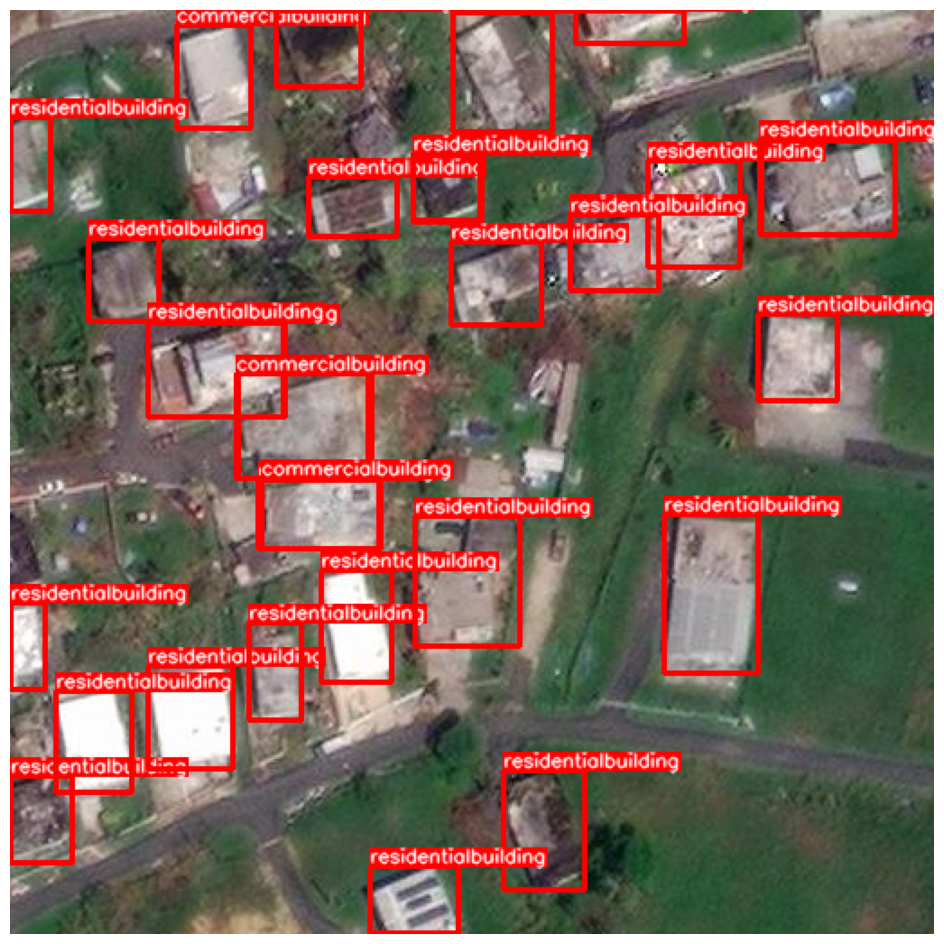

In [66]:
# visualizing the image with annotations from D1 (building detection model)
source_dir = '/content/drive/MyDrive/EYOpenScienceDataChallenge/code/ensembling'
category_id_dict = {
    "residentialbuilding": 0,
    "commercialbuilding": 1
}
category_id_to_name = {value: key for key, value in category_id_dict.items()}

image = cv2.imread(os.path.join(source_dir, 'Validation_Post_Event_001.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
category_ids = [category_id_dict[x[0]] for x in all_data[0]]
bboxes = [[x[2], x[3], x[4], x[5]] for x in all_data[0]]
print(len(all_data[0]))
visualize(image, bboxes, category_ids, category_id_to_name)

32


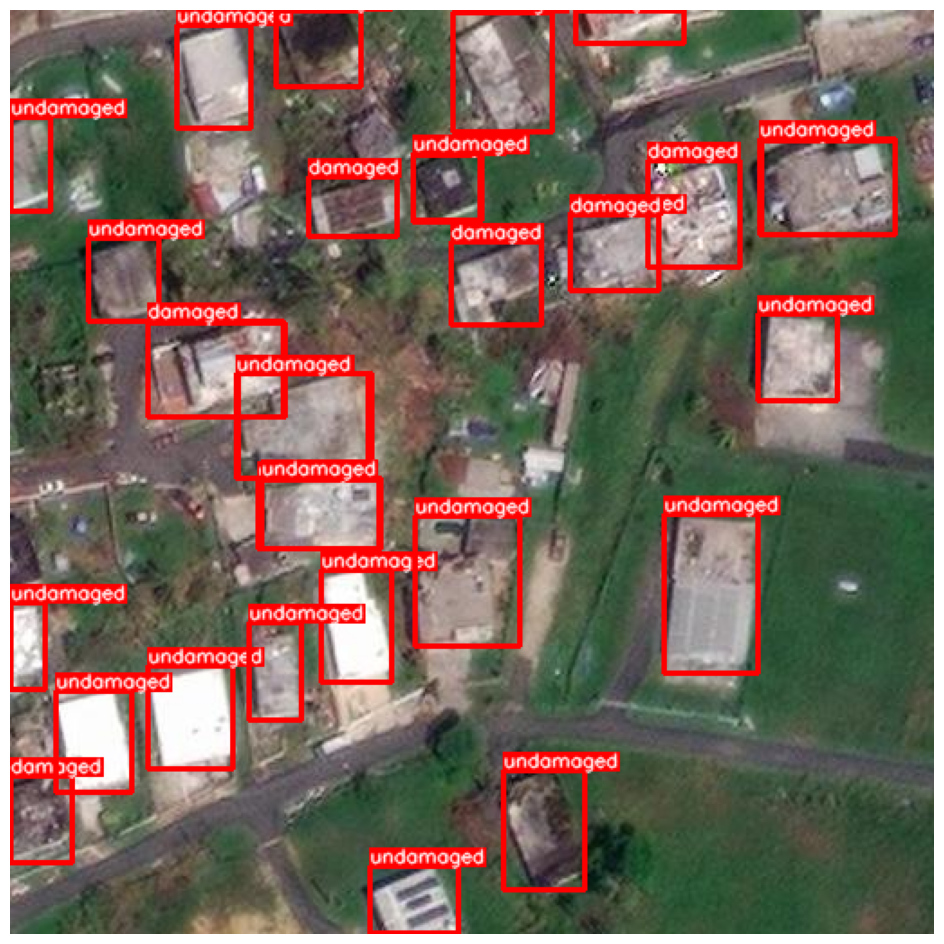

In [67]:
# visualizing the image with annotations from D2 (damage detection model)
source_dir = '/content/drive/MyDrive/EYOpenScienceDataChallenge/code/ensembling'
category_id_dict = {
    "damaged": 0,
    "undamaged": 1
}
category_id_to_name = {value: key for key, value in category_id_dict.items()}

image = cv2.imread(os.path.join(source_dir, 'Validation_Post_Event_001.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
category_ids = [category_id_dict[x[0]] for x in all_data[1]]
bboxes = [[x[2], x[3], x[4], x[5]] for x in all_data[1]]
print(len(all_data[1]))
visualize(image, bboxes, category_ids, category_id_to_name)

26


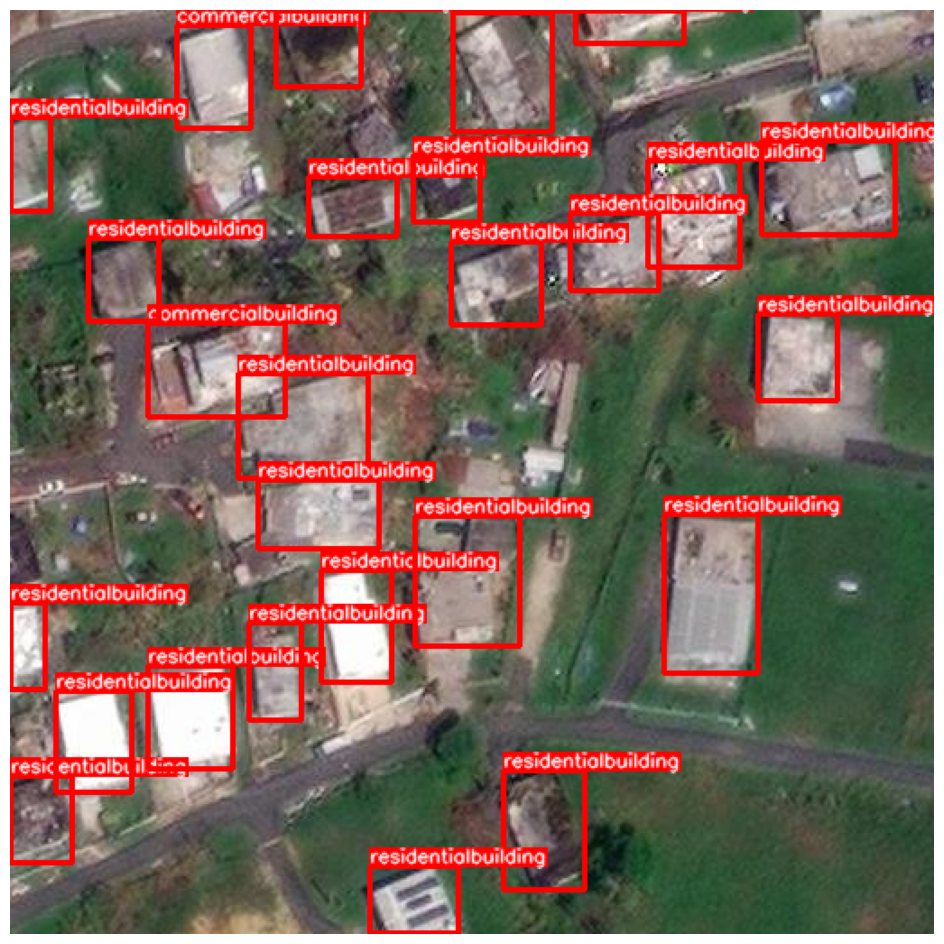

In [68]:
# visualizing the image with annotations from D1_nms (building detection model predictions after NMS)
source_dir = '/content/drive/MyDrive/EYOpenScienceDataChallenge/code/ensembling'
category_id_dict = {
    "residentialbuilding": 0,
    "commercialbuilding": 1
}
category_id_to_name = {value: key for key, value in category_id_dict.items()}

image = cv2.imread(os.path.join(source_dir, 'Validation_Post_Event_001.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
category_ids = [category_id_dict[x[0]] for x in all_data_nms[0]]
bboxes = [[x[2], x[3], x[4], x[5]] for x in all_data_nms[0]]
print(len(all_data_nms[0]))
visualize(image, bboxes, category_ids, category_id_to_name)

26


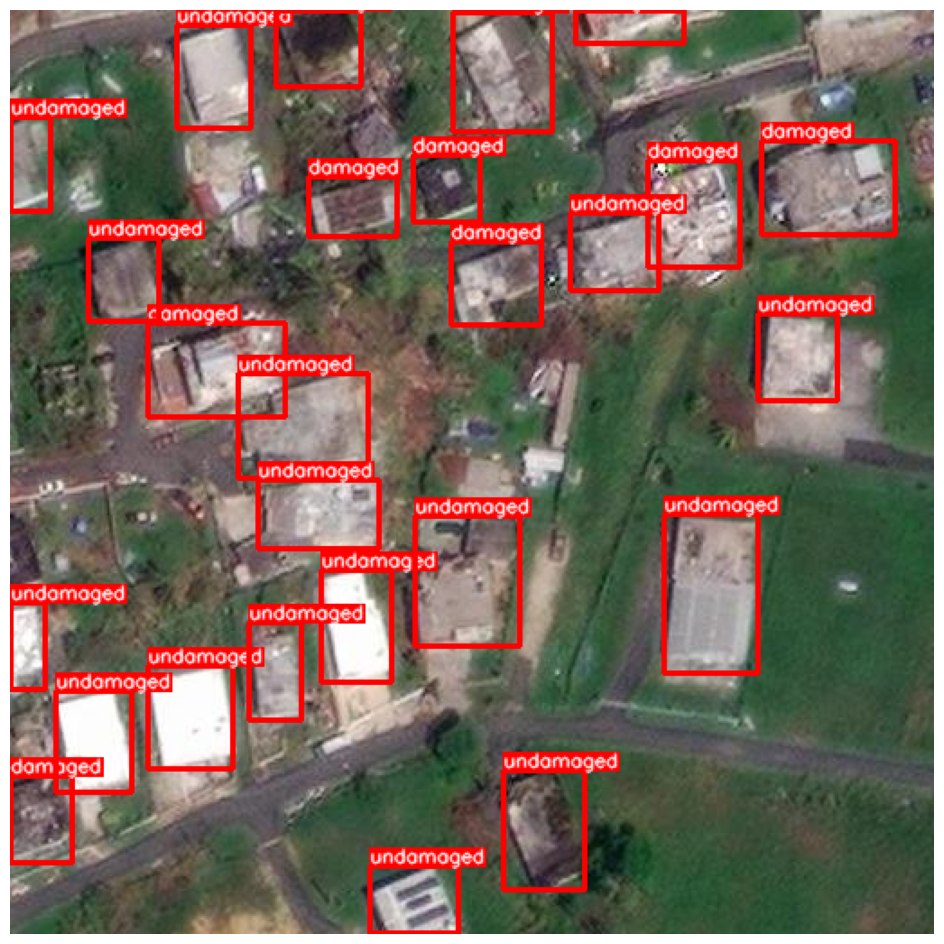

In [69]:
# visualizing the image with annotations from D2_nms (damage detection model)
source_dir = '/content/drive/MyDrive/EYOpenScienceDataChallenge/code/ensembling'
category_id_dict = {
    "damaged": 0,
    "undamaged": 1
}
category_id_to_name = {value: key for key, value in category_id_dict.items()}

image = cv2.imread(os.path.join(source_dir, 'Validation_Post_Event_001.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
category_ids = [category_id_dict[x[0]] for x in all_data_nms[1]]
bboxes = [[x[2], x[3], x[4], x[5]] for x in all_data_nms[1]]
print(len(all_data_nms[1]))
visualize(image, bboxes, category_ids, category_id_to_name)

26


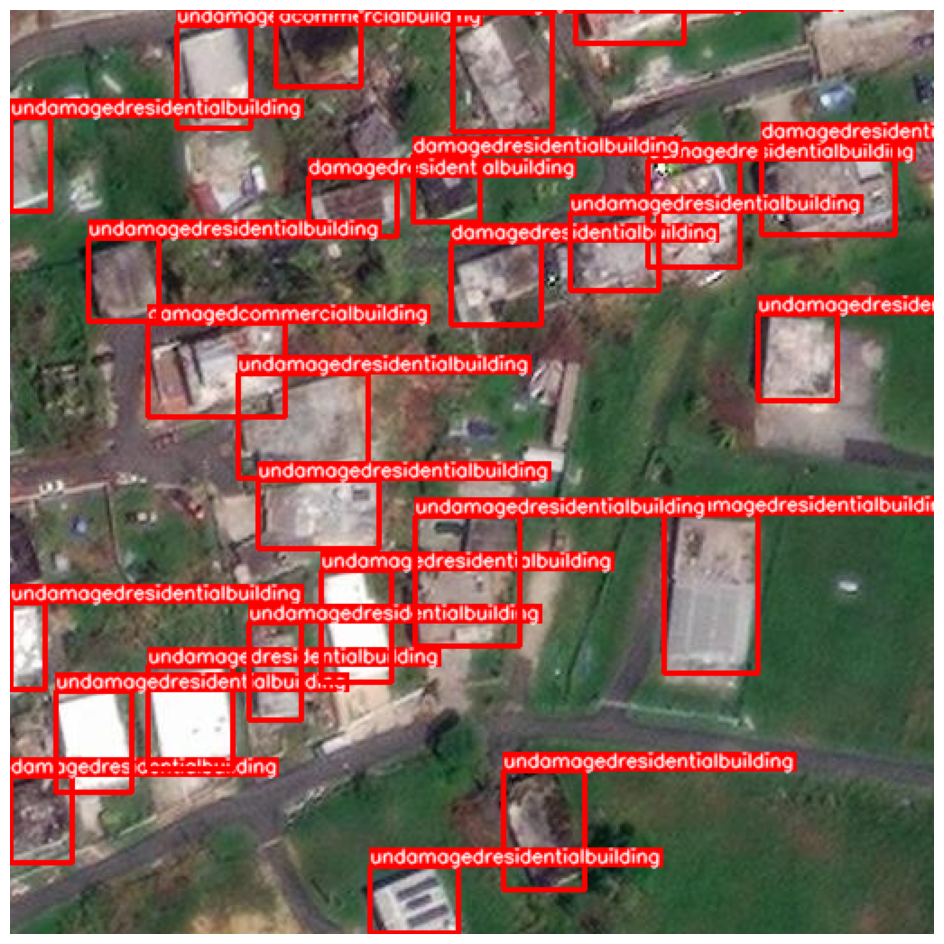

In [70]:
# now visualizing the image with ensemble annotations
source_dir = '/content/drive/MyDrive/EYOpenScienceDataChallenge/code/ensembling'
category_id_dict = {
    "undamagedresidentialbuilding": 0,
    "damagedresidentialbuilding": 1,
    "undamagedcommercialbuilding": 2,
    "damagedcommercialbuilding": 3
}
category_id_to_name = {value: key for key, value in category_id_dict.items()}

image = cv2.imread(os.path.join(source_dir, 'Validation_Post_Event_001.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
category_ids = [category_id_dict[x[0]] for x in ensemble_predictions]
bboxes = [[x[2], x[3], x[4], x[5]] for x in ensemble_predictions]
print(len(ensemble_predictions))
visualize(image, bboxes, category_ids, category_id_to_name)

Now, let's prepare the workflow so that we can run it for all images in the test set.

**NOTE: Untested as of 8th March 2.52p UTC**

In [72]:
# creating an generalized function for taking ensemble of D1_nms_i and D2_nms_i
# where D1_nms_i is the list of predictions from model 1 on Image i after taking an NMS
# and D2_nms_i is the list of predictions from model 2 on Image i after taking an NMS

def take_ensemble(d1_nms, d2_nms, merge_iou_thr):
  ensemble_predictions = []

  d1_nms = deque(d1_nms)
  d2_nms = d2_nms.copy()
  while d1_nms:
    c1_k_nms, s1_k_nms, xmin1_k_nms, ymin1_k_nms, xmax1_k_nms, ymax1_k_nms = d1_nms.popleft() # d1_k_nms, unpacked
    b1_k_nms = [xmin1_k_nms, ymin1_k_nms, xmax1_k_nms, ymax1_k_nms]
    candidates = []
    for d2_k_nms in d2_nms:
      b2_k_nms = [d2_k_nms[2], d2_k_nms[3], d2_k_nms[4], d2_k_nms[5]]
      if iou_compute(b1_k_nms, b2_k_nms) > merge_iou_thr:
        candidates.append(d2_k_nms)
    sorted_candidates = sorted(candidates, key=lambda x: x[1], reverse=True)
    d2_kp_nms = sorted_candidates[0]
    d2_nms.remove(sorted_candidates[0])

    # now, we merge d1_k_nms and d2_kp_nms

    # note that category merging assumes that model 1 being passed is the building detection model
    c_ensemble = str(d2_kp_nms[0]) + str(c1_k_nms) #concatenation
    s_ensemble = max(s1_k_nms, d2_kp_nms[1]) #maximum confidence

    #minimum enclosing box
    xmin_ensemble = min(xmin1_k_nms, d2_kp_nms[2])
    ymin_ensemble = min(ymin1_k_nms, d2_kp_nms[3])
    xmax_ensemble = max(xmax1_k_nms, d2_kp_nms[4])
    ymax_ensemble = max(ymax1_k_nms, d2_kp_nms[5])

    ensemble_predictions.append((c_ensemble,
                               s_ensemble,
                               xmin_ensemble,
                               ymin_ensemble,
                               xmax_ensemble,
                               ymax_ensemble))
  print("Ensemble generation done! Predictions left in D2_nms are:", len(d2_nms))
  return ensemble_predictions

In [ ]:
# point towards the directories towards the predictions by the two models

# Note that this snippet is untested as of now
building_model_dir = '/home/jovyan/PlanetaryComputerExamples/EYOpenScience/model_development_9_ensembling/building_detection_model'
damage_model_dir = '/home/jovyan/PlanetaryComputerExamples/EYOpenScience/model_development_9_ensembling/damage_detection_model'

# collecting all file paths for each prediction .txt from both models
file_paths = []
for filename in os.listdir(building_model_dir):
  if filename.endswith(".txt"):
    file_paths.append([os.path.join(building_model_dir, filename),
                       os.path.join(damage_model_dir, filename)])

# collecting all predictions for each image from both models, building detection model D1 and damage detection model D2
all_data = []
for filepath in file_paths:
  all_data.append(collect_data_from_files(filepath))

# now, every element in all_data is [D1_i, D2_i],
# where D1_i is the list of predictions on Image i from Model 1
# and D2_i is the list of predictions on Image i from Model 2

# lists D1_nms and D2_nms will now be stored in all_data_nms
all_data_nms = []
for data in all_data:
  all_data_nms.append([nonMaximumSuppression(data[0], 0.9), nonMaximumSuppression(data[1], 0.9)])

# now, every element in all_data_nms is [D1_nms_i, D2_nms_i],
# where D1_nms_i is obtained after taking an NMS on D1_i
# and D2_nms_i is obtained after taking an NMS on D2_i

# we now create an ensemble for each Image i and store it in ensemble predictions
ensemble_predictions = []
for data in all_data_nms:
  ensemble_predictions.append(take_ensemble(data[0], data[1], 0.9))

# now, we write the ensemble predictions for each Image i in a separate txt file
outdir = '/home/jovyan/PlanetaryComputerExamples/EYOpenScience/model_development_9_ensembling/Validation_Data_Results'
if not os.path.exists(outdir):
  os.makedirs(outdir)
count = 0
for filename in os.listdir(building_model_dir):
  output_file_path = os.path.join(outdir, filename)
  with open(output_file_path, 'w') as output_file:
    data_tuple = ensemble_predictions[count]
    class_names, confidences, left, top, right, bottom = data_tuple
    output_file.write(f"{class_names} {confidences} {left} {top} {right} {bottom}\n")
  count += 1

In [ ]:
# Define your source directory and the destination where the zip file will be created
source_dir = '/home/jovyan/PlanetaryComputerExamples/EYOpenScience/model_development_9_ensembling/Validation_Data_Results'
destination_zip = 'submission'

# Create a zip file from the directory
shutil.make_archive(destination_zip, 'zip', source_dir)

print(f"Directory {source_dir} has been successfully zipped into {destination_zip}.")

Directory /content/drive/MyDrive/EYOpenScienceDataChallenge/code/ensembling/model_development_6/submission_2 has been successfully zipped into submission.
